In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from jenks import jenks
from datetime import datetime
import numpy as np

In [2]:
path = 'data13to17Feb2018.csv'
df = pd.read_csv(path, usecols=['Time', 'Source', 'Destination', 'Protocol', 'Length']).dropna()

In [3]:
df = df[['Time', 'Length']]

In [4]:
df['Time']= pd.to_datetime(df['Time'])

In [5]:
df.head()

,Time,Length
0,2019-02-13 02:13:38.346809,152
1,2019-02-13 02:13:38.347297,40
2,2019-02-13 02:13:38.678841,88
3,2019-02-13 02:13:38.679018,40
4,2019-02-13 02:16:38.390502,152


In [8]:
df['Year'] = df['Time'].dt.year

In [9]:
df = df[df['Year'] > 1970]

In [10]:
df = df[['Time', 'Length']]

In [11]:
test_df = df[(df['Time'].dt.day == 13) & (df['Time'].dt.hour > 14) & (df['Time'].dt.hour < 16)]

In [13]:
test_df = test_df.iloc[800:10800]

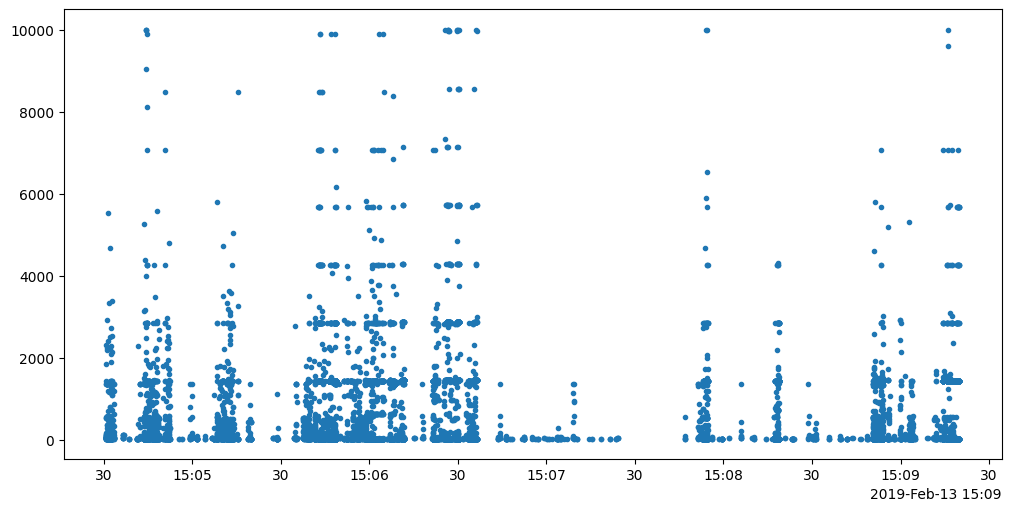

In [14]:
x = test_df['Time']
y = test_df['Length']

fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 5))
locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
formatter = mdates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)

axs.plot(x, y, alpha = 1, linestyle = '-', linewidth = 0, marker = 'o', markersize = 3)

plt.show()

In [15]:
%%time
lims = jenks(y, 6)

CPU times: user 479 ms, sys: 0 ns, total: 479 ms
Wall time: 476 ms


In [25]:
def put_to_cluster(value, lims):
    cluster_index = 0
    for i in range(len(lims) - 1):
        upper = lims[i]
        if value < upper:
            return cluster_index
        cluster_index += 1

In [26]:
test_df['Bucket'] = test_df['Length'].apply(lambda x: put_to_cluster(x, lims))

/tmp/ipykernel_2989/1569912331.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Bucket'] = test_df['Length'].apply(lambda x: put_to_cluster(x, lims))


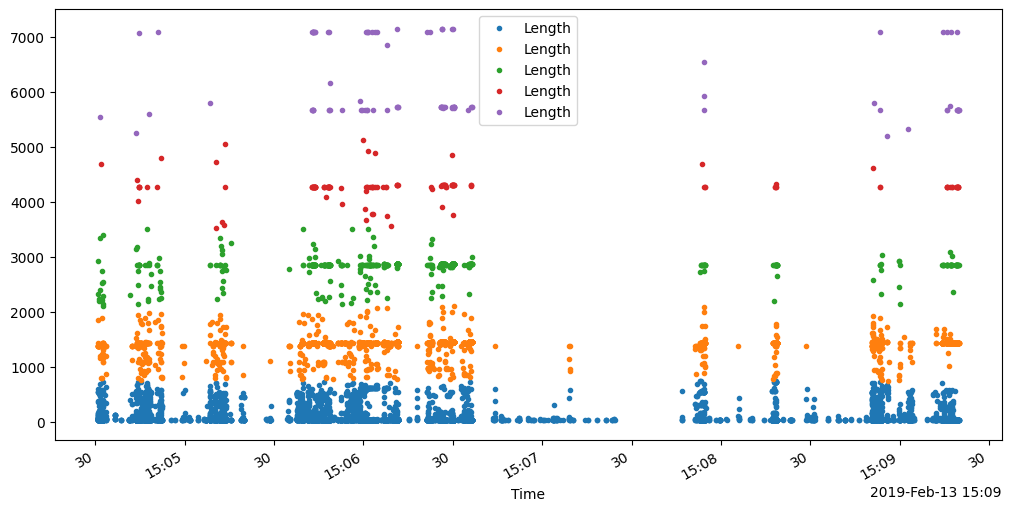

In [19]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 5))
locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
formatter = mdates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)

bucket_names = test_df.Bucket.unique()
test_df.reset_index().groupby('Bucket').plot(x='Time', y='Length', ax=axs, alpha = 1, linestyle = '-', linewidth = 0, marker = 'o', markersize = 3)

plt.show()

In [50]:
event_list = []
for index, row in test_df.iterrows():
    event_list.append(str(index) + ',' + str(row['Time']) + ',' + str(row['Length']))

In [51]:
def concise_sampling(event):
    N = len(event)
    a = 1.1 # We increase T by 10%
    max_size = N / 10

    # 1/T = selection probability
    T = 1

    #// S = Concise Sample
    S = {}
    S_help = {}
    S_help_real_index = {}
    len_S = 0

    for ev in event:
        
        real_idx, idx, val = ev.split(",")
        
        t_real_idx = int(real_idx)
        t_idx = datetime.strptime(idx, '%Y-%m-%d %H:%M:%S.%f')
        t_val = float(val)

        if np.random.random() < 1/T:
            if t_val in S:
                S[t_val] += 1
                S_help[t_val].append(t_idx)
                S_help_real_index[t_val].append(t_real_idx)
            else:
                S_help[t_val] = [t_idx]
                S_help_real_index[t_val] = [t_real_idx]
                S[t_val] = 1
            len_S += 1

    
        # Deletion step, Adjust sample when it gets too large
        
        if len_S> max_size:
            T_prime = a * T
            
            for s in S:
                for _ in range(S[s]):
                    if np.random.random() < 1 - T/T_prime:
                        S[s] -= 1
                        len_S -=1
                        if len(S_help[s]) == 1:
                            S_help[s].pop(0)
                            S_help_real_index[s].pop(0)
                        else:
                            S_help[s].pop(np.random.randint(0,len(S_help[s])-1))
                            S_help_real_index[s].pop(np.random.randint(0,len(S_help_real_index[s])-1))
            
            T = T_prime
    
    real_idx_list = []
    idx_list = []
    res_list = []

    for s in S:
        if S[s] > 0:
            for i in range(S[s]):
                idx_list.append(S_help[s][i])
                real_idx_list.append(S_help_real_index[s][i])
                res_list.append(s)

    return idx_list, res_list, real_idx_list

In [52]:
idx_list, res_list, real_idx_list = concise_sampling(event_list)

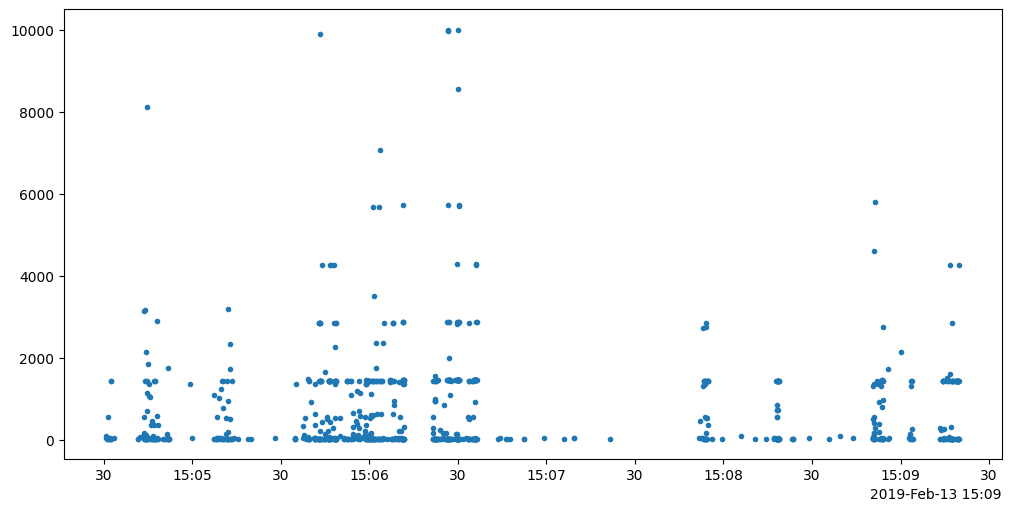

In [23]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 5))
locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
formatter = mdates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)

axs.plot(idx_list, res_list, alpha = 1, linestyle = '-', linewidth = 0, marker = 'o', markersize = 3)

plt.show()

In [42]:
lims = jenks(res_list, 6)

In [61]:
final_df = pd.DataFrame({'Time':idx_list, 'Length':res_list}, index=real_idx_list)
final_df['Bucket'] = final_df['Length'].apply(lambda x: put_to_cluster(x, lims))

In [62]:
final_df

,Time,Length,Bucket
489960,2019-02-13 15:04:43.709057,155.0,1.0
489610,2019-02-13 15:04:31.134378,48.0,1.0
489614,2019-02-13 15:04:31.568911,48.0,1.0
489709,2019-02-13 15:04:43.604001,48.0,1.0
489744,2019-02-13 15:04:43.799458,48.0,1.0
...,...,...,...
498266,2019-02-13 15:08:53.407240,733.0,2.0
498301,2019-02-13 15:08:53.531408,1099.0,3.0
498607,2019-02-13 15:09:03.891197,263.0,1.0
498930,2019-02-13 15:09:16.688110,578.0,2.0


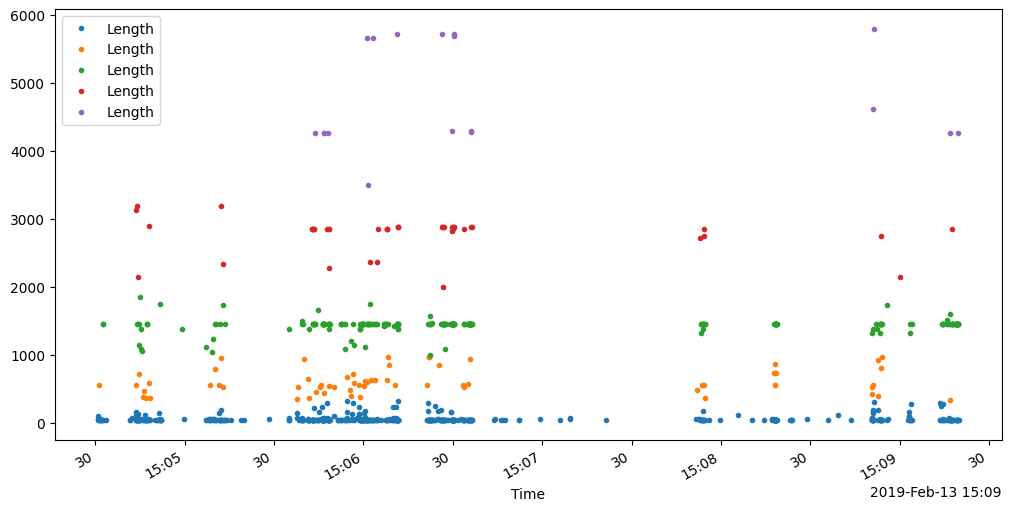

In [46]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 5))
locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
formatter = mdates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)

final_df.reset_index().groupby('Bucket').plot(x='Time', y='Length', ax=axs, alpha = 1, linestyle = '-', linewidth = 0, marker = 'o', markersize = 3)

plt.show()

In [65]:
merged_df = pd.merge(test_df, final_df, left_index=True, right_index=True)

In [66]:
merged_df

,Time_x,Length_x,Bucket_x,Time_y,Length_y,Bucket_y
489555,2019-02-13 15:04:30.904351,1448,3.0,2019-02-13 15:04:43.860870,1448.0,3.0
489579,2019-02-13 15:04:31.022368,40,1.0,2019-02-13 15:04:31.023891,40.0,1.0
489583,2019-02-13 15:04:31.027461,56,1.0,2019-02-13 15:04:30.859161,56.0,1.0
489610,2019-02-13 15:04:31.161071,48,1.0,2019-02-13 15:04:31.134378,48.0,1.0
489614,2019-02-13 15:04:31.249432,48,1.0,2019-02-13 15:04:31.568911,48.0,1.0
...,...,...,...,...,...,...
499489,2019-02-13 15:09:19.668661,40,1.0,2019-02-13 15:09:19.668661,40.0,1.0
499514,2019-02-13 15:09:19.768456,40,1.0,2019-02-13 15:09:19.768456,40.0,1.0
499516,2019-02-13 15:09:19.770115,1448,3.0,2019-02-13 15:09:19.770115,1448.0,3.0
499523,2019-02-13 15:09:19.803343,1448,3.0,2019-02-13 15:09:19.803343,1448.0,3.0


In [67]:
merged_df['IsSame'] = merged_df['Bucket_x'] == merged_df['Bucket_y']

In [72]:
merged_df.shape[0]

946

In [71]:
merged_df[merged_df['IsSame'] == True].shape[0]

939

In [73]:
outer_merged = pd.concat([test_df, final_df], axis=1)

In [74]:
outer_merged

,Time,Length,Bucket,Time,Length,Bucket
489531,2019-02-13 15:04:30.837149,155,1.0,NaT,NaN,NaN
489532,2019-02-13 15:04:30.837367,48,1.0,NaT,NaN,NaN
489533,2019-02-13 15:04:30.858358,548,2.0,NaT,NaN,NaN
489534,2019-02-13 15:04:30.858643,132,1.0,NaT,NaN,NaN
489535,2019-02-13 15:04:30.859161,56,1.0,NaT,NaN,NaN
...,...,...,...,...,...,...
499526,2019-02-13 15:09:19.810033,40,1.0,2019-02-13 15:09:19.810033,40.0,1.0
499527,2019-02-13 15:09:19.818845,5672,5.0,NaT,NaN,NaN
499528,2019-02-13 15:09:19.819361,1448,3.0,NaT,NaN,NaN
499529,2019-02-13 15:09:19.819454,40,1.0,NaT,NaN,NaN
